# Mass Transfer Lab COMSOL Data Analysis

#### Import libraries 

In [37]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import linregress
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d

#### Reading csv data and cleaning

In [38]:
df_123 = pd.read_csv("data/123_data_conc.csv")
df_128 = pd.read_csv("data/128_data_conc.csv")
df_133 = pd.read_csv("data/133_data_conc.csv")
df_140 = pd.read_csv("data/140_data_conc.csv")

df_123_flux = pd.read_csv("data/123-flux-data.csv")
df_128_flux = pd.read_csv("data/128-flux-data.csv")
df_133_flux = pd.read_csv("data/133-flux-data.csv")
df_140_flux = pd.read_csv("data/140-flux-data.csv")

df_1_0 = pd.read_csv("data/1ms-data.csv")
df_1_1 = pd.read_csv("data/1.1ms-data.csv")
df_1_4 = pd.read_csv("data/1.4ms-data.csv")
df_1_5 = pd.read_csv("data/1.5ms-data.csv")
df_1_7 = pd.read_csv("data/1.7ms-data.csv")
df_1_8 = pd.read_csv("data/1.8ms-data.csv")

df_123.head()

,x,y,T,c
0,0.000000,0.001165,316.538890,0.000000
1,0.000000,0.000547,316.538890,0.000000
2,0.000889,0.000946,316.531245,0.000914
3,0.001411,0.001557,316.537820,0.000152
4,0.000000,0.002294,316.538890,0.000000


#### Dataframe for COMSOL parameters

In [39]:
L = 0.555 # m
W = 0.200 # m
area = L * W # m^2

P = 101325 # Pa
P_atm = 1 # atm
D_AB = 2.634 / P # m^2 / s
R = 8.314 # J / mol K

flux_data = [-0.0017986, -0.0019379, -0.0020889, -0.0019698]
mflux_df = pd.DataFrame(flux_data, columns=["molar flux"])
mflux_df['air velocity (m/s)'] = [1.95072, 1.31064, 1.22936, 0.91948]
COMSOL_para = mflux_df
COMSOL_para

,molar flux,air velocity (m/s)
0,-0.001799,1.95072
1,-0.001938,1.31064
2,-0.002089,1.22936
3,-0.001970,0.91948


# Analysis Question 2
Determine the thicknesses of both thermal and concentration boundary layers and how they
vary with position x (at a fixed velocity) as well as with velocity (at a fixed position or
average along various positions). Clearly describe how you determine the boundary-layer
thickness. Explain the trends and what you expect based on theory, and the physical
reasoning of such trends. Please avoid nonlinear fits (because in general they do not
guarantee a unique solution and can be difficult to judge visually because subtleties in
curvature can be unobvious) and instead linearize your equations so as to enable use of
linear least-squares regression (which has a unique solution and is intuitive to judge
visually).

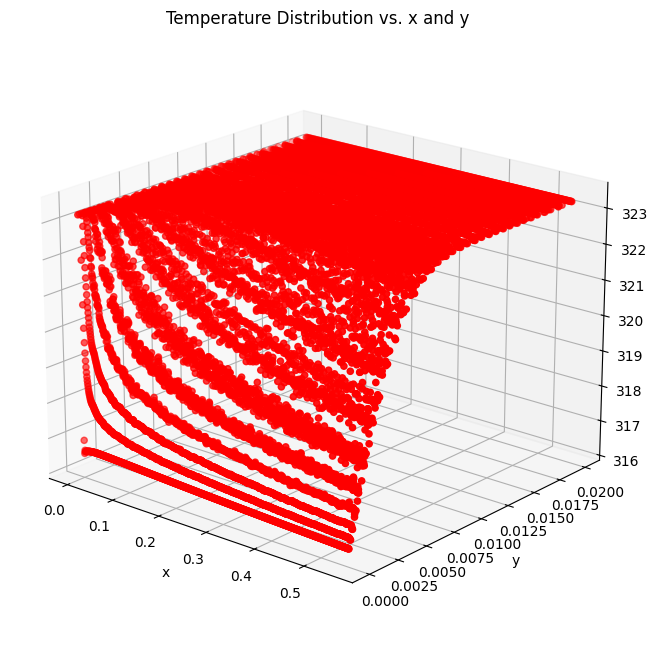

In [40]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the data points
ax.scatter(df_140['x'], df_140['y'], df_140['T'], c='r', marker='o')

# Set labels for the axes
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('T')

# Set a title for the plot
ax.set_title('Temperature Distribution vs. x and y')

# Rotate the plot for better visualization (optional)
ax.view_init(elev=20, azim=-50)  # Adjust elevation and azimuth angles

# Display the plot
plt.show()

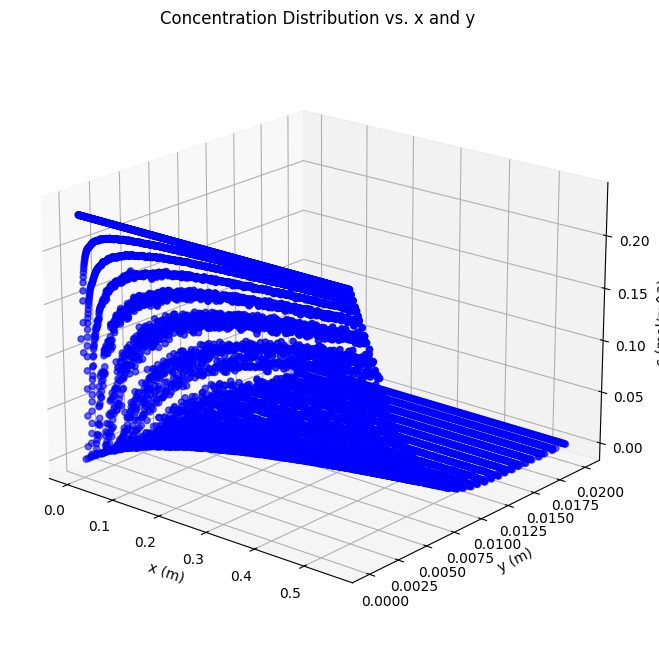

In [41]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the data points
ax.scatter(df_140['x'], df_140['y'], df_140['c'], c='b', marker='o')

# Set labels for the axes
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('c (mol/m^3)')

# Set a title for the plot
ax.set_title('Concentration Distribution vs. x and y')

# Rotate the plot for better visualization (optional)
ax.view_init(elev=20, azim=-50)  # Adjust elevation and azimuth angles

# Display the plot
plt.show()

#### Thermal Boundary Layer Thickness Determination

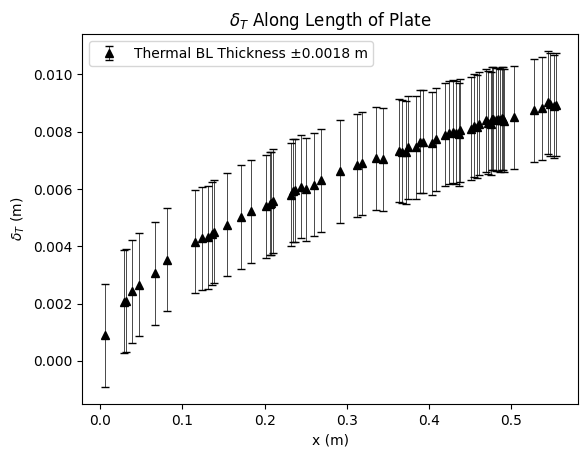

In [42]:
def get_T_BL_thickness(df):
    T_max = df["T"].max()
    T_min = df["T"].min()
    delta_T = T_max - T_min
    T_threshold = T_min + 0.99 * delta_T
    T_lower_bound = T_threshold - 0.002 * delta_T

    filtered_df = df[(df["T"] >= T_lower_bound) & (df["T"] <= T_threshold)]
    return filtered_df["x"], filtered_df["y"]

BL_thermal_140_x, BL_thermal_140_y = get_T_BL_thickness(df_140)

y_error_thermal = np.full_like(BL_thermal_140_y, 0.0018)
plt.errorbar(BL_thermal_140_x, BL_thermal_140_y, yerr=y_error_thermal, fmt='^', color="black",
             ecolor='black', capsize=3, linewidth = 0.5, label="Thermal BL Thickness ±0.0018 m")
plt.xlabel("x (m)")
plt.ylabel("$\delta_T$ (m)")
plt.title("$\delta_T$ Along Length of Plate")
plt.legend()
plt.show()

#### Log-log plot to determine scaling factor

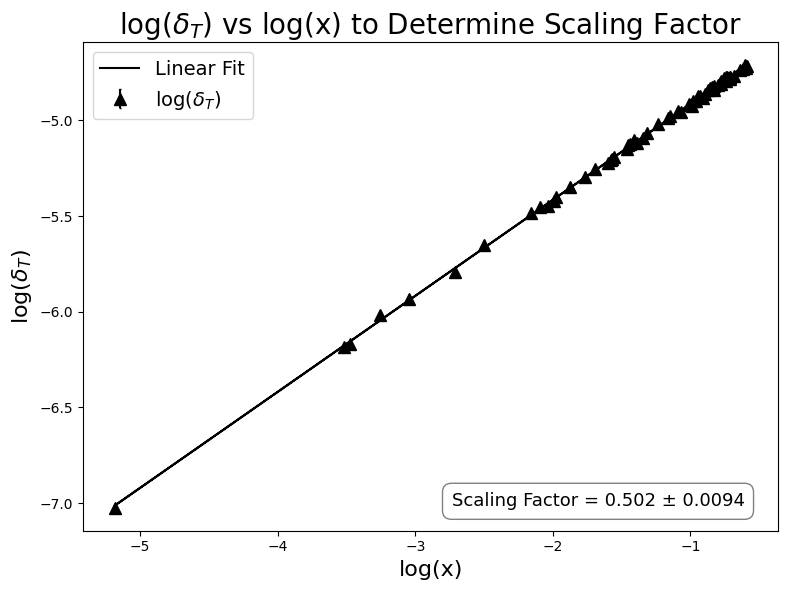

In [43]:
mask = (BL_thermal_140_x > 0) & (BL_thermal_140_y > 0)
x_log = np.log(BL_thermal_140_x[mask])
y_log = np.log(BL_thermal_140_y[mask])

log_y_error = y_error_thermal / abs(y_log)

slope, intercept, r_value, p_value, std_err = linregress(x_log, y_log)
y_fit = slope * x_log + intercept

residuals = y_log - y_fit
std_dev = np.std(residuals)

plt.figure(figsize=(8, 6))
plt.errorbar(x_log, y_log, yerr=log_y_error, fmt='^', markersize = 8, color="black",
             ecolor='black', capsize=1, label="log($\delta_T$)")
plt.plot(x_log, y_fit, color="black", label="Linear Fit")

# Annotate fit parameters
annotation = (f"Scaling Factor = {slope:.3f} ± {std_dev:.4f}")
plt.annotate(annotation, xy=(0.53, 0.05), xycoords="axes fraction",
             fontsize=13, color = "black", bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray"))

plt.xlabel("log(x)", fontsize=16)
plt.ylabel("log($\delta_T$)", fontsize=16)
plt.title("log($\delta_T$) vs log(x) to Determine Scaling Factor", fontsize=20)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

#### Concentration Boundary Layer Thickness Determination

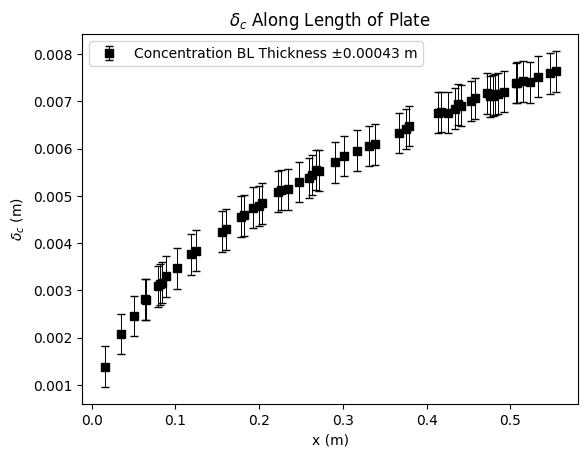

In [77]:
def get_c_BL_thickness(df):
    c_max = df["c"].max()
    c_min = df["c"].min()
    delta_c = c_max - c_min
    c_threshold = c_min + (0.1 * delta_c)
    c_lower_bound = c_threshold - 0.007 * delta_c

    filtered_df = df[(df["c"] >= c_lower_bound) & (df["c"] <= c_threshold)]
    return filtered_df["x"], filtered_df["y"]

BL_concentration_140_x, BL_concentration_140_y = get_c_BL_thickness(df_140)

y_error = np.full_like(BL_concentration_140_y, 0.00043)

plt.errorbar(BL_concentration_140_x, BL_concentration_140_y, yerr=y_error, fmt='s', color="black",
             ecolor='black', capsize=3, linewidth=0.7, label="Concentration BL Thickness ±0.00043 m")

plt.xlabel("x (m)")
plt.ylabel("$\delta_c$ (m)")
plt.title("$\delta_c$ Along Length of Plate")
plt.legend()
plt.show()

#### Log-log plot to determine scaling factor

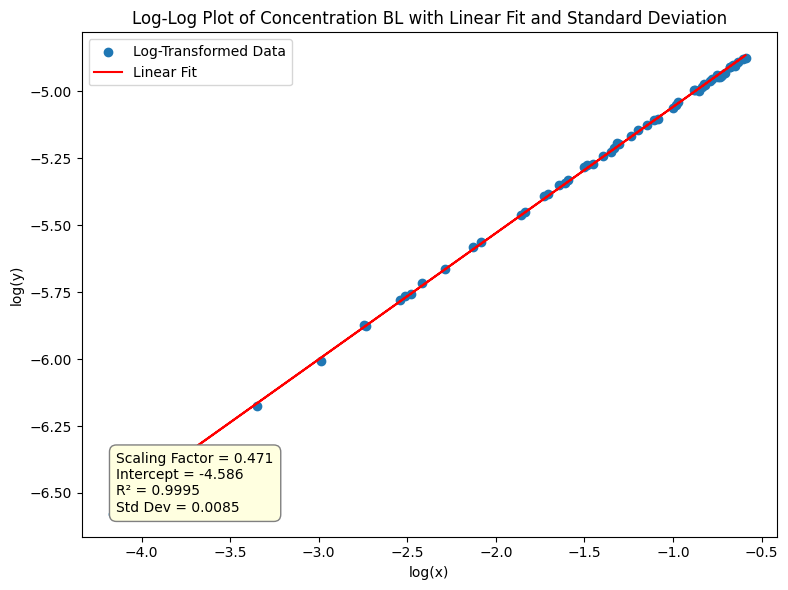

In [45]:
mask1 = (BL_concentration_140_x > 0) & (BL_concentration_140_y > 0)
x_log = np.log(BL_concentration_140_x[mask1])
y_log = np.log(BL_concentration_140_y[mask1])

# Perform linear regression on log-log data
slope, intercept, r_value, p_value, std_err = linregress(x_log, y_log)
y_fit = slope * x_log + intercept

# Compute residuals and standard deviation
residuals = y_log - y_fit
std_dev = np.std(residuals)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x_log, y_log, label="Log-Transformed Data")
plt.plot(x_log, y_fit, color="red", label="Linear Fit")

# Annotate fit parameters
annotation = (f"Scaling Factor = {slope:.3f}\n"
              f"Intercept = {intercept:.3f}\n"
              f"R² = {r_value**2:.4f}\n"
              f"Std Dev = {std_dev:.4f}")
plt.annotate(annotation, xy=(0.05, 0.05), xycoords="axes fraction",
             fontsize=10, bbox=dict(boxstyle="round,pad=0.5", fc="lightyellow", ec="gray"))

plt.xlabel("log(x)")
plt.ylabel("log(y)")
plt.title("Log-Log Plot of Concentration BL with Linear Fit and Standard Deviation")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print(np.mean(BL_concentration_140_y))

#### Overlay thermal and concentration boundary layer to verify that thermal BL is greater than concentration BL

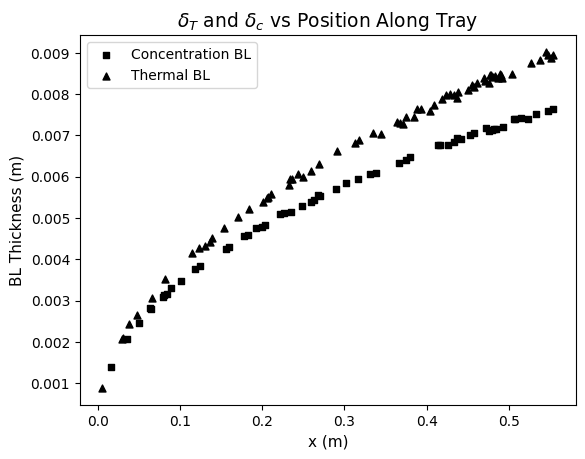

In [46]:
plt.scatter(BL_concentration_140_x, BL_concentration_140_y, marker="s", color = "black", s=13)
plt.scatter(BL_thermal_140_x, BL_thermal_140_y, marker="^", color = "black", s=25)
plt.xlabel("x (m)", fontsize=11)
plt.ylabel("BL Thickness (m)", fontsize=11)
plt.title("$\delta_T$ and $\delta_c$ vs Position Along Tray", fontsize=13.5)
plt.legend(["Concentration BL", "Thermal BL"])
plt.show()

#### Evaluating thermal and concentration boundary layer thickness for all velocities

In [47]:
BL_thermal_123_x, BL_thermal_123_y = get_T_BL_thickness(df_123)
BL_thermal_128_x, BL_thermal_128_y = get_T_BL_thickness(df_128)
BL_thermal_133_x, BL_thermal_133_y = get_T_BL_thickness(df_133)
BL_thermal_140_x, BL_thermal_140_y = get_T_BL_thickness(df_140)
BL_thermal_pt1_x, BL_thermal_pt1_y = get_T_BL_thickness(df_1_0)
BL_thermal_pt2_x, BL_thermal_pt2_y = get_T_BL_thickness(df_1_1)
BL_thermal_pt3_x, BL_thermal_pt3_y = get_T_BL_thickness(df_1_4)
BL_thermal_pt4_x, BL_thermal_pt4_y = get_T_BL_thickness(df_1_5)
BL_thermal_pt5_x, BL_thermal_pt5_y = get_T_BL_thickness(df_1_7)
BL_thermal_pt6_x, BL_thermal_pt6_y = get_T_BL_thickness(df_1_8)

BL_concentration_123_x, BL_concentration_123_y = get_c_BL_thickness(df_123)
BL_concentration_128_x, BL_concentration_128_y = get_c_BL_thickness(df_128)
BL_concentration_133_x, BL_concentration_133_y = get_c_BL_thickness(df_133)
BL_concentration_140_x, BL_concentration_140_y = get_c_BL_thickness(df_140)
BL_concentration_pt1_x, BL_concentration_pt1_y = get_c_BL_thickness(df_1_0)
BL_concentration_pt2_x, BL_concentration_pt2_y = get_c_BL_thickness(df_1_1)
BL_concentration_pt3_x, BL_concentration_pt3_y = get_c_BL_thickness(df_1_4)
BL_concentration_pt4_x, BL_concentration_pt4_y = get_c_BL_thickness(df_1_5)
BL_concentration_pt5_x, BL_concentration_pt5_y = get_c_BL_thickness(df_1_7)
BL_concentration_pt6_x, BL_concentration_pt6_y = get_c_BL_thickness(df_1_8)

In [48]:
# plt.scatter(BL_thermal_123_x, BL_thermal_123_y, color="red", label="0.92 m/s", s=5)
# # plt.scatter(BL_thermal_pt1_x, BL_thermal_pt1_y, color="purple", label="1.0 m/s", s=5)
# plt.scatter(BL_thermal_pt2_x, BL_thermal_pt2_y, color="orange", label="1.1 m/s", s=5)
# # plt.scatter(BL_thermal_128_x, BL_thermal_128_y, color="orange", label="1.2 m/s", s=5)
# plt.scatter(BL_thermal_133_x, BL_thermal_133_y, color="green", label="1.3 m/s", s=5)
# # plt.scatter(BL_thermal_pt3_x, BL_thermal_pt3_y, color="pink", label="1.4 m/s", s=5)
# # plt.scatter(BL_thermal_pt4_x, BL_thermal_pt4_y, color="brown", label="1.5 m/s", s=5)
# # plt.scatter(BL_thermal_pt5_x, BL_thermal_pt5_y, color="brown", label="1.7 m/s", s=5)
# # plt.scatter(BL_thermal_pt6_x, BL_thermal_pt6_y, color="brown", label="1.8 m/s", s=5)
# plt.scatter(BL_thermal_140_x, BL_thermal_140_y, color="blue", label="1.9 m/s", s=5)

# plt.xlabel("x (m)")
# plt.ylabel("BL Thickness (m)")
# plt.title("Thermal Boundary Layer Threshold for All Measured Air Velocities")
# plt.legend()
# plt.show()

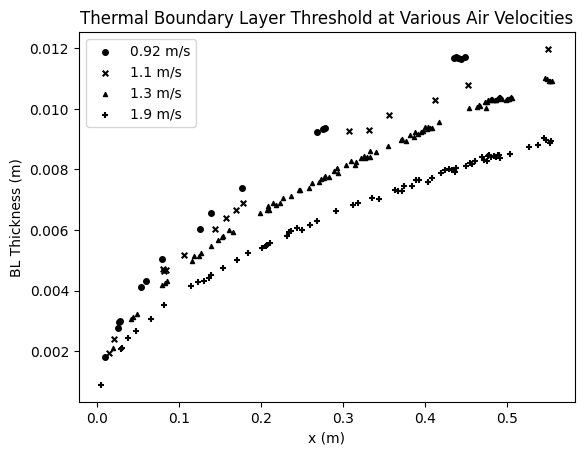

In [49]:
import random

# Use same marker set as in the concentration plot
markers = ['.', '^', 'o', 'x', '+']
random_markers = random.sample(markers, 5)

# Updated thermal BL plot with same format
plt.scatter(BL_thermal_123_x, BL_thermal_123_y, marker="o",
            color='black', s=16, label='0.92 m/s')
plt.scatter(BL_thermal_pt2_x, BL_thermal_pt2_y, marker="x",
            color='black', s=16, label='1.1 m/s')
plt.scatter(BL_thermal_133_x, BL_thermal_133_y, marker="^",
            color='black', s=8.5, label='1.3 m/s')
plt.scatter(BL_thermal_140_x, BL_thermal_140_y, marker="+",
            color='black', s=24, label='1.9 m/s')

plt.xlabel("x (m)")
plt.ylabel("BL Thickness (m)")
plt.title("Thermal Boundary Layer Threshold at Various Air Velocities")
plt.legend()
plt.show()


#### Average thermal boundary layer thickness

In [50]:
# this is to narrow the range of x values that are considered when calculating our average BL thickness
# since we don't have an x value that contains data for all of the air speeds
lower_bound = 0.25
upper_bound = 0.32
filter_for_thermal_BL_123 = (BL_thermal_123_x >= lower_bound) & (BL_thermal_123_x <= upper_bound)
filter_for_thermal_BL_128 = (BL_thermal_128_x >= lower_bound) & (BL_thermal_128_x <= upper_bound)
filter_for_thermal_BL_133 = (BL_thermal_133_x >= lower_bound) & (BL_thermal_133_x <= upper_bound)
filter_for_thermal_BL_140 = (BL_thermal_140_x >= lower_bound) & (BL_thermal_140_x <= upper_bound)
filter_for_thermal_BL_pt1 = (BL_thermal_pt1_x >= lower_bound) & (BL_thermal_pt1_x <= upper_bound)
filter_for_thermal_BL_pt2 = (BL_thermal_pt2_x >= lower_bound) & (BL_thermal_pt2_x <= upper_bound)
filter_for_thermal_BL_pt3 = (BL_thermal_pt3_x >= lower_bound) & (BL_thermal_pt3_x <= upper_bound)
filter_for_thermal_BL_pt4 = (BL_thermal_pt4_x >= lower_bound) & (BL_thermal_pt4_x <= upper_bound)
filter_for_thermal_BL_pt5 = (BL_thermal_pt5_x >= lower_bound) & (BL_thermal_pt5_x <= upper_bound)
filter_for_thermal_BL_pt6 = (BL_thermal_pt6_x >= lower_bound) & (BL_thermal_pt6_x <= upper_bound)

avg_thermal_BL_123 = BL_thermal_123_y[filter_for_thermal_BL_123].mean()
avg_thermal_BL_128 = BL_thermal_128_y[filter_for_thermal_BL_128].mean()
avg_thermal_BL_133 = BL_thermal_133_y[filter_for_thermal_BL_133].mean()
avg_thermal_BL_140 = BL_thermal_140_y[filter_for_thermal_BL_140].mean()
avg_thermal_BL_pt1 = BL_thermal_pt1_y[filter_for_thermal_BL_pt1].mean()
avg_thermal_BL_pt2 = BL_thermal_pt2_y[filter_for_thermal_BL_pt2].mean()
avg_thermal_BL_pt3 = BL_thermal_pt3_y[filter_for_thermal_BL_pt3].mean()
avg_thermal_BL_pt4 = BL_thermal_pt4_y[filter_for_thermal_BL_pt4].mean()
avg_thermal_BL_pt5 = BL_thermal_pt5_y[filter_for_thermal_BL_pt5].mean()
avg_thermal_BL_pt6 = BL_thermal_pt6_y[filter_for_thermal_BL_pt6].mean()

print("Average thermal Boundary Layer for 0.9 m/s =", avg_thermal_BL_123)
print("Avg TBL for 1 m/s = ", avg_thermal_BL_pt1)
print("Avg TBL for 1.1 m/s = ", avg_thermal_BL_pt2)
print("Average thermal Boundary Layer for 1.2 m/s =", avg_thermal_BL_128)
print("Average thermal Boundary Layer for 1.3 m/s =", avg_thermal_BL_133)
print("Avg TBL for 1.4 m/s = ", avg_thermal_BL_pt3)
print("Avg TBL for 1.5 m/s = ", avg_thermal_BL_pt4)
print("Average thermal Boundary Layer for 1.9 m/s =", avg_thermal_BL_140)




Average thermal Boundary Layer for 0.9 m/s = 0.009309520643539633
Avg TBL for 1 m/s =  0.009607073395999699
Avg TBL for 1.1 m/s =  0.0092567924689487
Average thermal Boundary Layer for 1.2 m/s = 0.008165681750457747
Average thermal Boundary Layer for 1.3 m/s = 0.007868880084579016
Avg TBL for 1.4 m/s =  nan
Avg TBL for 1.5 m/s =  nan
Average thermal Boundary Layer for 1.9 m/s = 0.006464163662038401


In [51]:
# plt.scatter(BL_concentration_123_x, BL_concentration_123_y, color='red', label='0.92 m/s', s=6)
# # plt.scatter(BL_concentration_pt1_x, BL_concentration_pt1_y, color="purple", label="1.0 m/s", s=5)
# plt.scatter(BL_concentration_pt2_x, BL_concentration_pt2_y, color="black", label="1.1 m/s", s=6)
# plt.scatter(BL_concentration_128_x, BL_concentration_128_y, color='orange', label='1.2 m/s', s=6)
# plt.scatter(BL_concentration_133_x, BL_concentration_133_y, color='green', label='1.3 m/s', s=6)
# # plt.scatter(BL_concentration_pt3_x, BL_concentration_pt3_y, color="pink", label="1.4 m/s", s=5)
# # plt.scatter(BL_concentration_pt4_x, BL_concentration_pt4_y, color="brown", label="1.5 m/s", s=5)
# # plt.scatter(BL_concentration_pt5_x, BL_concentration_pt5_y, color="brown", label="1.7 m/s")
# # plt.scatter(BL_concentration_pt6_x, BL_concentration_pt6_y, color="brown", label="1.8 m/s", s=5)
# plt.scatter(BL_concentration_140_x, BL_concentration_140_y, color='blue', label='1.9 m/s', s=6)

# plt.xlabel("x (m)")
# plt.ylabel("BL Thickness (m)")
# plt.title("Concentration Boundary Layer Threshold for All Measured Air Velocities")
# plt.legend()
# plt.show()

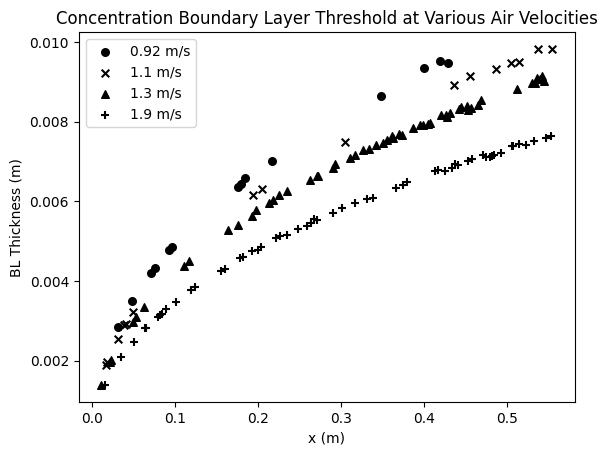

In [52]:
import random
markers = ['.', '^', 'o', 'x', '+']
random_markers = random.sample(markers, 5)
plt.scatter(BL_concentration_123_x, BL_concentration_123_y, marker="o", color='black', s=30, label='0.92 m/s')
plt.scatter(BL_concentration_pt2_x, BL_concentration_pt2_y, marker="x", color='black', s=30, label='1.1 m/s')
plt.scatter(BL_concentration_133_x, BL_concentration_133_y, marker="^", color='black', s=30, label='1.3 m/s')
plt.scatter(BL_concentration_140_x, BL_concentration_140_y, marker="+", color='black', s=30, label='1.9 m/s')

plt.xlabel("x (m)")
plt.ylabel("BL Thickness (m)")
plt.title("Concentration Boundary Layer Threshold at Various Air Velocities")
plt.legend()
plt.show()

In [53]:
# this is to narrow the range of x values that are considered when calculating our average BL thickness
# since we don't have an x value that contains data for all of the air speeds
lower_bound1 = 0.25
upper_bound1 = 0.32
filter_for_concentration_BL_123 = (BL_concentration_123_x >= lower_bound1) & (BL_concentration_123_x <= upper_bound1)
filter_for_concentration_BL_128 = (BL_concentration_128_x >= lower_bound1) & (BL_concentration_128_x <= upper_bound1)
filter_for_concentration_BL_133 = (BL_concentration_133_x >= lower_bound1) & (BL_concentration_133_x <= upper_bound1)
filter_for_concentration_BL_140 = (BL_concentration_140_x >= lower_bound1) & (BL_concentration_140_x <= upper_bound1)
filter_for_concentration_pt1 = (BL_concentration_pt1_x >= lower_bound1) & (BL_concentration_pt1_x <= upper_bound1)
filter_for_concentration_pt2 = (BL_concentration_pt2_x >= lower_bound1) & (BL_concentration_pt2_x <= upper_bound1)
filter_for_concentration_pt3 = (BL_concentration_pt3_x >= lower_bound1) & (BL_concentration_pt3_x <= upper_bound1)
filter_for_concentration_pt4 = (BL_concentration_pt4_x >= lower_bound1) & (BL_concentration_pt4_x <= upper_bound1)
filter_for_concentration_pt5 = (BL_concentration_pt5_x >= lower_bound1) & (BL_concentration_pt5_x <= upper_bound1)
filter_for_concentration_pt6 = (BL_concentration_pt6_x >= lower_bound1) & (BL_concentration_pt6_x <= upper_bound1)

avg_concentration_BL_123 = BL_concentration_123_y[filter_for_concentration_BL_123].mean()
avg_concentration_BL_128 = BL_concentration_128_y[filter_for_concentration_BL_128].mean()
avg_concentration_BL_133 = BL_concentration_133_y[filter_for_concentration_BL_133].mean()
avg_concentration_BL_140 = BL_concentration_140_y[filter_for_concentration_BL_140].mean()
avg_concentration_BL_pt1 = BL_concentration_pt1_y[filter_for_concentration_pt1].mean()
avg_concentration_BL_pt2 = BL_concentration_pt2_y[filter_for_concentration_pt2].mean()
avg_concentration_BL_pt3 = BL_concentration_pt3_y[filter_for_concentration_pt3].mean()
avg_concentration_BL_pt4 = BL_concentration_pt4_y[filter_for_concentration_pt4].mean()
avg_concentration_BL_pt5 = BL_concentration_pt5_y[filter_for_concentration_pt5].mean()
avg_concentration_BL_pt6 = BL_concentration_pt6_y[filter_for_concentration_pt6].mean()

print("Average concentration Boundary Layer for 0.9 m/s =", avg_concentration_BL_123)
print('Avg CBL for 1.0 m/s = ', avg_concentration_BL_pt1)
print('Avg CBL for 1.1 m/s = ', avg_concentration_BL_pt2)
print("Average concentration Boundary Layer for 1.2 m/s =", avg_concentration_BL_128)
print("Average concentration Boundary Layer for 1.3 m/s =", avg_concentration_BL_133)
print('Avg CBL for 1.4 m/s = ', avg_concentration_BL_pt3)
print('Avg CBL for 1.5 m/s = ', avg_concentration_BL_pt4)
print("Average concentration Boundary Layer for 1.9 m/s =", avg_concentration_BL_140)

Average concentration Boundary Layer for 0.9 m/s = nan
Avg CBL for 1.0 m/s =  nan
Avg CBL for 1.1 m/s =  0.0074895569207448
Average concentration Boundary Layer for 1.2 m/s = 0.0070106806404711995
Average concentration Boundary Layer for 1.3 m/s = 0.006831312253837128
Avg CBL for 1.4 m/s =  0.0067195117716983
Avg CBL for 1.5 m/s =  0.006473406919217834
Average concentration Boundary Layer for 1.9 m/s = 0.005631160048798371


#### Deterimining how boundary layer thickness scales with air velocity

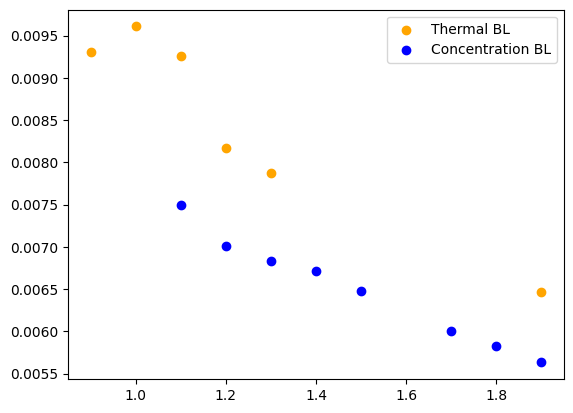

In [54]:
air_velocities = np.array([0.9,1,1.1,1.2,1.3,1.4,1.5,1.7,1.8,1.9])

conc_BLs = np.array([
    avg_concentration_BL_123,
    avg_concentration_BL_pt1,
    avg_concentration_BL_pt2,
    avg_concentration_BL_128,
    avg_concentration_BL_133,
    avg_concentration_BL_pt3,
    avg_concentration_BL_pt4,
    avg_concentration_BL_pt5,
    avg_concentration_BL_pt6,
    avg_concentration_BL_140,
])
thermal_BLs = np.array([
    avg_thermal_BL_123,
    avg_thermal_BL_pt1,
    avg_thermal_BL_pt2,
    avg_thermal_BL_128,
    avg_thermal_BL_133,
    avg_thermal_BL_pt3,
    avg_thermal_BL_pt4,
    avg_thermal_BL_pt5,
    avg_thermal_BL_pt6,
    avg_thermal_BL_140
                       ])
plt.scatter(air_velocities, thermal_BLs, color="orange", label="Thermal BL")
plt.scatter(air_velocities, conc_BLs, color="blue", label="Concentration BL")
plt.legend()

Perform linear regression on the log values.

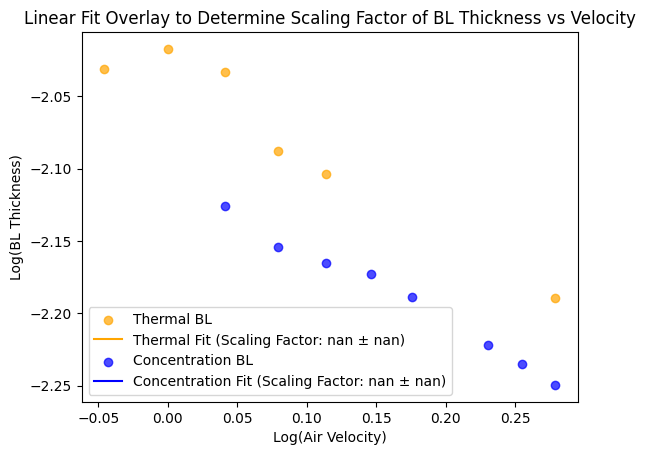

Thermal Slope: nan ± nan
Conc Slope: nan ± nan


In [55]:
log_thermal_BL = np.log10(thermal_BLs)
log_conc_BL = np.log10(conc_BLs)
log_air_velocity = np.log10(air_velocities)

slope_thermal, intercept_thermal, r_value_thermal, p_value_thermal, std_err_thermal = linregress(log_air_velocity, log_thermal_BL)
slope_conc, intercept_conc, r_value_conc, p_value_conc, std_err_conc = linregress(log_air_velocity, log_conc_BL)

plt.scatter(log_air_velocity, log_thermal_BL, label="Thermal BL", color="orange", alpha=0.7)
plt.plot(log_air_velocity, slope_thermal * log_air_velocity + intercept_thermal, color="orange", label=f"Thermal Fit (Scaling Factor: {slope_thermal:.2f} ± {std_err_thermal:.2f})")

plt.scatter(log_air_velocity, log_conc_BL, label="Concentration BL", color="b", alpha=0.7)
plt.plot(log_air_velocity, slope_conc * log_air_velocity + intercept_conc, color="b", label=f"Concentration Fit (Scaling Factor: {slope_conc:.2f} ± {std_err_conc:.2f})")

plt.xlabel("Log(Air Velocity)")
plt.ylabel("Log(BL Thickness)")
plt.title("Linear Fit Overlay to Determine Scaling Factor of BL Thickness vs Velocity")
plt.legend()
plt.show()

print(f"Thermal Slope: {slope_thermal:.2f} ± {std_err_thermal:.2f}")
print(f"Conc Slope: {slope_conc:.2f} ± {std_err_conc:.2f}")

# Question 3
Calculate the mass transfer coefficient $k_m$ as a function of the distance along the water tray
for one of the inlet velocities studied in the experiment. As mentioned in Eq. (4), the ratio
of mass flux to concentration difference driving force defines the mass transfer coefficient.
Explain the trend and what you expect based on theory, and the physical reasoning of such
trends. Here again avoid nonlinear fits and instead linearize your equations so as to enable
use of linear least-squares regression.

$$N_A = K_{mA} \Delta c_A$$    
$$k_m=\frac{N_A(x)}{c_0(x)-c_{bulk}(x)}$$

#### Determining $K_{mA}$

In [56]:
df_140
m_140 = df_140
m_140 = m_140.rename(columns={'c (mol/m^3)': 'c'})
m_140['c_mass'] = m_140['c'] * 0.018015
m_140

,x,y,T,c,c_mass
0,0.000000,0.000613,323.205560,0.000000,0.000000
1,0.000000,0.000326,323.205560,0.000000,0.000000
2,0.000420,0.000508,323.204494,0.000110,0.000002
3,0.000567,0.000837,323.204073,0.000107,0.000002
4,0.000000,0.001083,323.205560,0.000000,0.000000
...,...,...,...,...,...
13232,0.553600,0.000000,316.359608,0.233000,0.004197
13233,0.554300,0.000138,316.580570,0.228127,0.004110
13234,0.555000,0.000138,316.580389,0.227921,0.004106
13235,0.554300,0.000000,316.358596,0.233000,0.004197


In [57]:
mflux_140 = df_140_flux
mflux_140['c_mass'] = mflux_140['c'] * 0.018015
mflux_140['mass flux'] = mflux_140['mol_flux'] * 0.018015
mflux_140.head()

,x,y,T,c,mol_flux,c_mass,mass flux
0,0.0,0.000000,323.20556,0.1165,-0.024828,0.002099,-0.000447
1,0.0,0.000148,323.20556,0.0000,-0.025991,0.000000,-0.000468
2,0.0,0.000326,323.20556,0.0000,0.000265,0.000000,0.000005
3,0.0,0.000613,323.20556,0.0000,0.000190,0.000000,0.000003
4,0.0,0.001083,323.20556,0.0000,0.000150,0.000000,0.000003


In [58]:
df_140_filtered = m_140.loc[m_140.groupby("x")["T"].idxmax()]
df_140_flux_filtered = mflux_140[mflux_140["y"] == 0]

In [59]:
merged_df = pd.merge(df_140_flux_filtered, df_140_filtered, on="x")
merged_df = merged_df.drop(columns=["y_y", "y_x"])
merged_df = merged_df.rename(columns={
    "c_x": "c_0",
    "c_y": "c_b",
    "c_mass_x": "c_mass_0",
    "c_mass_y": "c_mass_b"
})
merged_df['mass_flux'] = merged_df['mol_flux'] * 0.018015

#### Define a function that will calculate $k_m$

In [60]:
def determine_mt_coeff(flux, c_0, c_b):
    return flux/(c_0 - c_b)

#### Calculation of $k_m(x)$

In [61]:
merged_df["mt_coeff"] = merged_df.apply(
    lambda row: determine_mt_coeff(row["mass flux"], row["c_mass_0"], row["c_mass_b"]), axis=1
)
mt_df = merged_df
mt_df

,x,T_x,c_0,mol_flux,c_mass_0,mass flux,T_y,c_b,c_mass_b,mass_flux,mt_coeff
0,0.000000,323.205560,0.1165,-0.024828,0.002099,-0.000447,323.205560,0.000000,0.000000e+00,-0.000447,-0.213116
1,0.000700,316.921698,0.2330,-0.026502,0.004197,-0.000477,323.148623,0.011460,2.064481e-04,-0.000477,-0.119625
2,0.001400,316.549989,0.2330,-0.018673,0.004197,-0.000336,322.858602,0.041345,7.448261e-04,-0.000336,-0.097432
3,0.002100,316.641206,0.2330,-0.014541,0.004197,-0.000262,322.442369,0.067353,1.213365e-03,-0.000262,-0.087786
4,0.002799,316.600938,0.2330,-0.012671,0.004197,-0.000228,322.060750,0.084988,1.531057e-03,-0.000228,-0.085610
...,...,...,...,...,...,...,...,...,...,...,...
789,0.552201,316.360178,0.2330,-0.000955,0.004197,-0.000017,316.908237,0.220864,3.978864e-03,-0.000017,-0.078672
790,0.552900,316.359769,0.2330,-0.000954,0.004197,-0.000017,316.880529,0.221473,3.989839e-03,-0.000017,-0.082798
791,0.553600,316.359608,0.2330,-0.000953,0.004197,-0.000017,316.856919,0.222011,3.999534e-03,-0.000017,-0.086698
792,0.554300,316.358596,0.2330,-0.000948,0.004197,-0.000017,316.844825,0.222276,4.004295e-03,-0.000017,-0.088428


In [72]:
mt_df['mt_coeff'] = mt_df['mt_coeff'] * -1
mt_df.replace([np.inf, -np.inf], 1, inplace=True)
mt_df_clean = mt_df[(mt_df["mt_coeff"] >= 0) & (mt_df["mt_coeff"] <= 1)]
mt_df_clean["mt_coeff"].min()
mt_df_clean = mt_df_clean[:-30]

#### Visualization

Text(0.5, 1.0, 'Mass Transfer Coefficient vs position $x$')

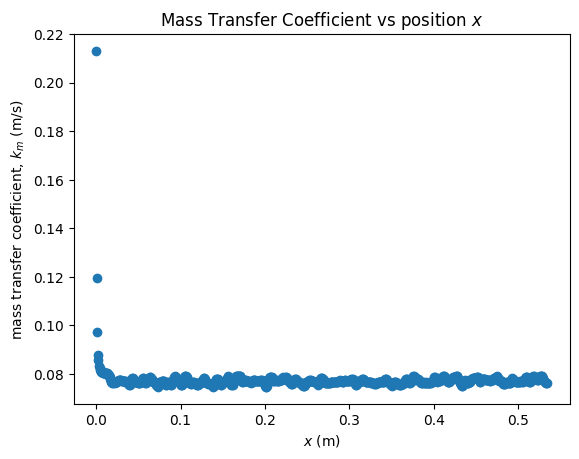

In [63]:
plt.scatter(mt_df_clean["x"], mt_df_clean["mt_coeff"])
plt.xlabel("$x$ (m)")
plt.ylabel("mass transfer coefficient, $k_m$ (m/s)")
plt.title("Mass Transfer Coefficient vs position $x$")

/var/folders/91/rvx7nt9d0xl443dqh1kf4qx40000gn/T/ipykernel_21401/2769206709.py:18: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale("log")
/var/folders/91/rvx7nt9d0xl443dqh1kf4qx40000gn/T/ipykernel_21401/2769206709.py:19: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


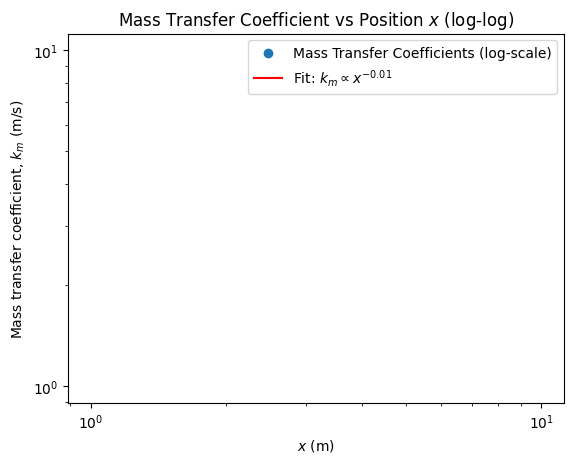

In [64]:
x_vals = mt_df_clean["x"]
km_vals = mt_df_clean["mt_coeff"]

mask = (x_vals > 0) & (km_vals > 0)
x_vals = x_vals[mask]
km_vals = km_vals[mask]

log_x = np.log(x_vals)
log_km = np.log(km_vals)

slope, intercept, r_value, *_ = linregress(log_x, log_km)
fit_km = np.exp(intercept) * x_vals**slope

plt.figure()
plt.scatter(log_x, log_km, label="Mass Transfer Coefficients (log-scale)")
plt.plot(log_x, log_km, label=f"Fit: $k_m \\propto x^{{{slope:.2f}}}$", color ="r")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("$x$ (m)")
plt.ylabel("Mass transfer coefficient, $k_m$ (m/s)")
plt.title("Mass Transfer Coefficient vs Position $x$ (log-log)")
plt.legend()
plt.show()

# Question 5
Correlate the average value of km as a function of inlet velocity in the form of dimensionless groups. In particular, 
. Specify the characteristic length and transport properties used for calculating the dimensionless groups. Determine the value of C2 and compare the result with experiment and with theory. Note that you have not conducted experiments necessary to determine C1 or C3 independently, so focus only on C2. What do you conclude about the flow in your system? In a separate plot, plot the average value of km at a certain inlet velocity with the average boundary-layer thickness at that velocity, for all velocities. Comment on what is physically driving the scaling of km with velocity. Here again avoid nonlinear fits and instead linearize your equations so as to enable use of linear least-squares regression
#### System Parameters.

In [73]:
L = 0.555  # m
D = 2.6e-5  # m²/s
rho = 1.2  # kg/m³
mu = 1.8e-5  # Pa·s (kg/m·s)

km_film_123 = D_AB / avg_concentration_BL_123
km_film_128 = D_AB / avg_concentration_BL_128
km_film_133 = D_AB / avg_concentration_BL_133
km_film_140 = D_AB / avg_concentration_BL_140
km_film_140

np.float64(0.004616377197598379)

In [66]:
velocities = COMSOL_para["air velocity (m/s)"]

In [67]:
Re = rho * velocities * L / mu
Sc = mu / (rho * D)
Sh = km_vals * L / D

log_Re = np.log(Re)
log_Sh = np.log(Sh)

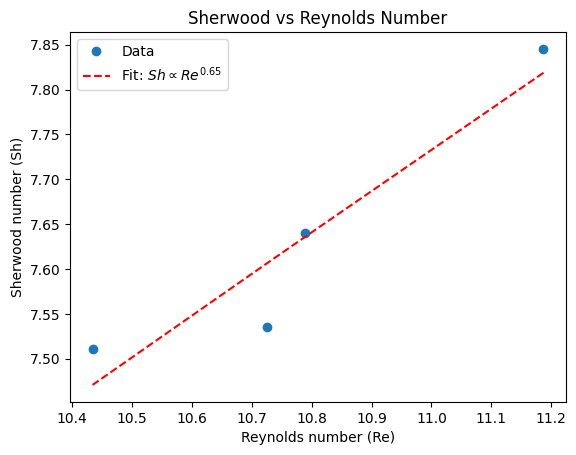

Fit: Sh ∝ Re^0.6540
Intercept (ln scale): 0.4773
R²: 0.8926
Standard error on slope: 0.0015


In [68]:
velocities = np.array([1.95072, 1.31064, 1.22936, 0.91948])
km_values_film = np.array([km_film_140, km_film_128, km_film_133, km_film_140])

Sh_filtered = log_Sh[:len(velocities)]
Re_filtered = log_Re[:len(velocities)]

slope, intercept, r_value, *_ = linregress(np.log(Re_filtered), np.log(Sh_filtered))
Sh_fit = np.exp(intercept) * Re_filtered**slope

plt.figure()
plt.plot(Re_filtered, Sh_filtered, 'o', label="Data")
plt.plot(Re_filtered, Sh_fit, 'r--', label=f"Fit: $Sh \\propto Re^{{{slope:.2f}}}$")
plt.xlabel("Reynolds number (Re)")
plt.ylabel("Sherwood number (Sh)")
plt.title("Sherwood vs Reynolds Number")
plt.legend()
plt.show()

print(f"Fit: Sh ∝ Re^{slope:.4f}")
print(f"Intercept (ln scale): {intercept:.4f}")
print(f"R²: {r_value**2:.4f}")
print(f"Standard error on slope: {std_err:.4f}")

In [69]:
conc_BLs
km_all = D_AB/conc_BLs
km_all

array([       nan,        nan, 0.00347091, 0.00370799, 0.00380535,
       0.00386867, 0.00401575, 0.00432994, 0.00446225, 0.00461638])

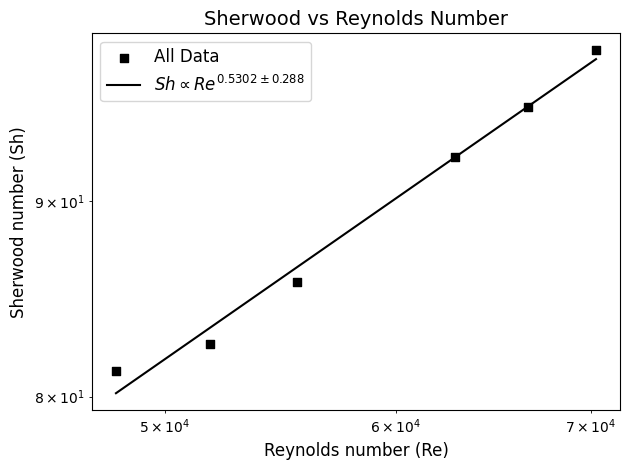

Fit (last 6 pts): Sh ∝ Re^0.5302
Intercept (ln scale): -1.3320
R²: 0.9883
Standard error on slope: 0.0288


In [98]:
# Compute Re and Sh as before
Re_all = (rho * air_velocities * L) / mu
Sh_all = (km_all * L) / D

# Take only the last 6 data points for fitting
Re_fit = Re_all[-6:]
Sh_fit = Sh_all[-6:]

# Log transform for regression
log_Re_fit = np.log(Re_fit)
log_Sh_fit = np.log(Sh_fit)

# Linear regression on last 6 points
slope, intercept, r_value, p_value, std_err = linregress(log_Re_fit, log_Sh_fit)
Sh_fit_line = np.exp(intercept) * Re_fit**slope

# Plotting
plt.figure()
plt.scatter(Re_fit, Sh_fit, color='black', label="All Data", marker="s")
plt.plot(Re_fit, Sh_fit_line, 'black', label=fr"$Sh \propto Re^{{{slope:.4f} \pm 0.288}}$")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Reynolds number (Re)", fontsize=12)
plt.ylabel("Sherwood number (Sh)", fontsize=12)
plt.title("Sherwood vs Reynolds Number", fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Print fit summary
print(f"Fit (last 6 pts): Sh ∝ Re^{slope:.4f}")
print(f"Intercept (ln scale): {intercept:.4f}")
print(f"R²: {r_value**2:.4f}")
print(f"Standard error on slope: {std_err:.4f}")


In [71]:
total_evap_rate_123 = df_123_flux["mass_flux"].mean() * area
total_evap_rate_128 = df_128_flux["mass_flux"].mean() * area
total_evap_rate_133 = df_133_flux["mass_flux"].mean() * area
total_evap_rate_140 = df_140_flux["mass_flux"].mean() * area

print(f"Total evaporation rate from COMSOL at 123°F: {abs(total_evap_rate_123):.6e} kg/s")
print(f"Total evaporation rate from COMSOL at 128°F: {abs(total_evap_rate_128):.6e} kg/s")
print(f"Total evaporation rate from COMSOL at 133°F: {abs(total_evap_rate_133):.6e} kg/s")
print(f"Total evaporation rate from COMSOL at 140°F: {abs(total_evap_rate_140):.6e} kg/s")


KeyError: 'mass_flux'